In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
# 한글 폰트 설치
!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 설정
plt.rc('font', family='NanumGothic')

# GPU 설정 확인
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Selecting previously unselected package fonts-nanum.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ===== 셀 2: 데이터 로드 =====

from google.colab import files

print("다음 7개의 CSV 파일을 업로드해주세요:")
print("1. open_source_combined.csv")
print("2. normal_LLAMA.csv")
print("3. normal_gemini.csv")
print("4. normal_gpt.csv")
print("5. specific_LLAMA.csv")
print("6. specific_gemini.csv")
print("7. specific_gpt.csv")

uploaded = files.upload()

다음 7개의 CSV 파일을 업로드해주세요:
1. open_source_combined.csv
2. normal_LLAMA.csv
3. normal_gemini.csv
4. normal_gpt.csv
5. specific_LLAMA.csv
6. specific_gemini.csv
7. specific_gpt.csv


Saving normal_gemini.csv to normal_gemini.csv
Saving normal_gpt.csv to normal_gpt.csv
Saving normal_LLAMA.csv to normal_LLAMA.csv
Saving open_source_combined.csv to open_source_combined.csv
Saving specific_gemini.csv to specific_gemini.csv
Saving specific_gpt.csv to specific_gpt.csv
Saving specific_LLAMA.csv to specific_LLAMA.csv


In [3]:
# ===== 셀 3: 데이터 로드 및 전처리 =====

# 데이터 로드
data_dict = {}

# 오픈소스 데이터
data_dict['opensource'] = pd.read_csv('open_source_combined.csv')

# LLM 생성 데이터 - normal
data_dict['llama_normal'] = pd.read_csv('normal_LLAMA.csv')
data_dict['gemini_normal'] = pd.read_csv('normal_gemini.csv')
data_dict['gpt_normal'] = pd.read_csv('normal_gpt.csv')

# LLM 생성 데이터 - specific
data_dict['llama_specific'] = pd.read_csv('specific_LLAMA.csv')
data_dict['gemini_specific'] = pd.read_csv('specific_gemini.csv')
data_dict['gpt_specific'] = pd.read_csv('specific_gpt.csv')

# 데이터 확인 및 전처리
print("="*80)
print("데이터 전처리 중...")
print("="*80)

for key in data_dict:
    df = data_dict[key]

    # 결측치 확인
    print(f"\n[{key}]")
    print(f"  전처리 전 shape: {df.shape}")
    print(f"  결측치: dialogue={df['dialogue'].isna().sum()}, label={df['label'].isna().sum()}")

    # dialogue나 label이 NaN인 행 제거
    df = df.dropna(subset=['dialogue', 'label'])

    # label이 숫자가 아닌 값 확인
    try:
        df['label'] = pd.to_numeric(df['label'], errors='coerce')
    except:
        pass

    # label을 정수로 변환 (NaN은 제거)
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    # 0과 1이 아닌 label 제거 (혹시 모를 이상값)
    df = df[df['label'].isin([0, 1])]

    # 빈 문자열 제거
    df = df[df['dialogue'].str.strip() != '']

    # 인덱스 리셋
    df = df.reset_index(drop=True)

    data_dict[key] = df
    print(f"  전처리 후 shape: {df.shape}")

# 데이터 통계 출력
print("\n"+"="*80)
print("데이터 통계")
print("="*80)
for key, df in data_dict.items():
    print(f"\n[{key}]")
    print(f"  총 샘플 수: {len(df)}")
    print(f"  정상(0): {(df['label']==0).sum()} ({(df['label']==0).sum()/len(df)*100:.1f}%)")
    print(f"  피싱(1): {(df['label']==1).sum()} ({(df['label']==1).sum()/len(df)*100:.1f}%)")

# LLM별 데이터 통합
llm_datasets = {
    'LLAMA': pd.concat([data_dict['llama_normal'], data_dict['llama_specific']], ignore_index=True),
    'Gemini': pd.concat([data_dict['gemini_normal'], data_dict['gemini_specific']], ignore_index=True),
    'GPT': pd.concat([data_dict['gpt_normal'], data_dict['gpt_specific']], ignore_index=True)
}

print("\n"+"="*80)
print("LLM 통합 데이터 통계")
print("="*80)
for llm_name, df in llm_datasets.items():
    print(f"\n[{llm_name}]")
    print(f"  총 샘플 수: {len(df)}")
    print(f"  정상(0): {(df['label']==0).sum()} ({(df['label']==0).sum()/len(df)*100:.1f}%)")
    print(f"  피싱(1): {(df['label']==1).sum()} ({(df['label']==1).sum()/len(df)*100:.1f}%)")

print("\n데이터 전처리 완료!")

데이터 전처리 중...

[opensource]
  전처리 전 shape: (4978, 2)
  결측치: dialogue=0, label=0
  전처리 후 shape: (4978, 2)

[llama_normal]
  전처리 전 shape: (1902, 2)
  결측치: dialogue=0, label=0
  전처리 후 shape: (1902, 2)

[gemini_normal]
  전처리 전 shape: (1615, 2)
  결측치: dialogue=0, label=0
  전처리 후 shape: (1615, 2)

[gpt_normal]
  전처리 전 shape: (1599, 2)
  결측치: dialogue=1, label=1
  전처리 후 shape: (1598, 2)

[llama_specific]
  전처리 전 shape: (1536, 2)
  결측치: dialogue=0, label=0
  전처리 후 shape: (1536, 2)

[gemini_specific]
  전처리 전 shape: (1615, 2)
  결측치: dialogue=0, label=0
  전처리 후 shape: (1615, 2)

[gpt_specific]
  전처리 전 shape: (1498, 2)
  결측치: dialogue=0, label=1
  전처리 후 shape: (1497, 2)

데이터 통계

[opensource]
  총 샘플 수: 4978
  정상(0): 2828 (56.8%)
  피싱(1): 2150 (43.2%)

[llama_normal]
  총 샘플 수: 1902
  정상(0): 1392 (73.2%)
  피싱(1): 510 (26.8%)

[gemini_normal]
  총 샘플 수: 1615
  정상(0): 1058 (65.5%)
  피싱(1): 557 (34.5%)

[gpt_normal]
  총 샘플 수: 1598
  정상(0): 1057 (66.1%)
  피싱(1): 541 (33.9%)

[llama_specific]
  총 샘플 수: 1536

In [4]:
# ===== 셀 4: 유틸리티 함수 정의 =====

def create_tokenizer(texts, max_words=10000):
    """토크나이저 생성"""
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    return tokenizer

def prepare_sequences(tokenizer, texts, max_len=100):
    """텍스트를 시퀀스로 변환 및 패딩"""
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded

def build_lstm_model(vocab_size, embedding_dim=128, lstm_units=64, max_len=100):
    """Bi-LSTM 모델 구성"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(lstm_units//2)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def evaluate_model(model, tokenizer, test_df, max_len=100):
    """모델 평가 및 메트릭 계산"""
    X_test = prepare_sequences(tokenizer, test_df['dialogue'].values, max_len)
    y_test = test_df['label'].values

    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return {
        'accuracy': acc,
        'f1_score': f1,
        'confusion_matrix': cm,
        'y_true': y_test,
        'y_pred': y_pred
    }

def plot_confusion_matrix(cm, title):
    """Confusion Matrix 시각화"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['정상(0)', '피싱(1)'],
                yticklabels=['정상(0)', '피싱(1)'])
    plt.title(title, fontsize=14, pad=20)
    plt.ylabel('실제 레이블')
    plt.xlabel('예측 레이블')
    plt.tight_layout()
    plt.show()

def print_evaluation_results(results, dataset_name):
    """평가 결과 출력"""
    print(f"\n{'='*80}")
    print(f"평가 데이터: {dataset_name}")
    print(f"{'='*80}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1-Score: {results['f1_score']:.4f}")
    print(f"\nConfusion Matrix:")
    print(results['confusion_matrix'])
    print(f"\nClassification Report:")
    print(classification_report(results['y_true'], results['y_pred'],
                                target_names=['정상(0)', '피싱(1)']))

print("유틸리티 함수 정의 완료!")

유틸리티 함수 정의 완료!


In [5]:
# ===== 셀 5: 하이퍼파라미터 설정 =====

MAX_WORDS = 10000
MAX_LEN = 100
TEST_SIZE = 0.2
RANDOM_STATE = 42

# 결과 저장용
models = {}
tokenizers = {}
all_results = {}

print("하이퍼파라미터:")
print(f"  MAX_WORDS: {MAX_WORDS}")
print(f"  MAX_LEN: {MAX_LEN}")
print(f"  TEST_SIZE: {TEST_SIZE}")
print(f"  RANDOM_STATE: {RANDOM_STATE}")

하이퍼파라미터:
  MAX_WORDS: 10000
  MAX_LEN: 100
  TEST_SIZE: 0.2
  RANDOM_STATE: 42


In [6]:
# ===== 셀 6: OpenSource 모델 학습 =====

print("="*80)
print("[1/4] OpenSource 데이터로 모델 학습")
print("="*80)

os_data = data_dict['opensource']

# 토크나이저 생성
tokenizers['opensource'] = create_tokenizer(os_data['dialogue'].values, MAX_WORDS)

# 데이터 준비
X_os = prepare_sequences(tokenizers['opensource'], os_data['dialogue'].values, MAX_LEN)
y_os = os_data['label'].values

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_os, y_os, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_os
)

print(f"학습 데이터: {len(X_train)} 샘플")
print(f"검증 데이터: {len(X_val)} 샘플")

# 모델 생성
models['opensource'] = build_lstm_model(MAX_WORDS, max_len=MAX_LEN)

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 학습
history_os = models['opensource'].fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nOpenSource 모델 학습 완료!")

[1/4] OpenSource 데이터로 모델 학습
학습 데이터: 3982 샘플
검증 데이터: 996 샘플
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8082 - loss: 0.4280 - val_accuracy: 0.9779 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9943 - loss: 0.0220 - val_accuracy: 0.9880 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9958 - loss: 0.0109 - val_accuracy: 0.9980 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 7.2237e-04 - val_accuracy: 0.9960 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 1.0000 - loss: 4.6991e-04 - val_accuracy: 0.9970 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.0000 - loss: 2.8470e-04 - val_accuracy: 0.9960 - val_loss: 0.0157 - learning_rate: 0.0010
Epoch 7/30

In [7]:
# ===== 셀 7: LLAMA 모델 학습 =====

print("="*80)
print("[2/4] LLAMA 데이터로 모델 학습")
print("="*80)

llama_data = llm_datasets['LLAMA']

# 토크나이저 생성
tokenizers['LLAMA'] = create_tokenizer(llama_data['dialogue'].values, MAX_WORDS)

# 데이터 준비
X_llama = prepare_sequences(tokenizers['LLAMA'], llama_data['dialogue'].values, MAX_LEN)
y_llama = llama_data['label'].values

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_llama, y_llama, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_llama
)

print(f"학습 데이터: {len(X_train)} 샘플")
print(f"검증 데이터: {len(X_val)} 샘플")

# 모델 생성
models['LLAMA'] = build_lstm_model(MAX_WORDS, max_len=MAX_LEN)

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 학습
history_llama = models['LLAMA'].fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nLLAMA 모델 학습 완료!")

[2/4] LLAMA 데이터로 모델 학습
학습 데이터: 2750 샘플
검증 데이터: 688 샘플
Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7976 - loss: 0.3735 - val_accuracy: 0.9956 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9966 - loss: 0.0117 - val_accuracy: 0.9985 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9971 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 1.0000 - loss: 5.4705e-04 - val_accuracy: 0.9985 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 5/30
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 3.8678e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 1.0000 - loss: 3.8783e-04 - val_accuracy: 0.9985 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 6/30
86/86 ━━━━━━━━━━━━

In [8]:
# ===== 셀 8: Gemini 모델 학습 =====

print("="*80)
print("[3/4] Gemini 데이터로 모델 학습")
print("="*80)

gemini_data = llm_datasets['Gemini']

# 토크나이저 생성
tokenizers['Gemini'] = create_tokenizer(gemini_data['dialogue'].values, MAX_WORDS)

# 데이터 준비
X_gemini = prepare_sequences(tokenizers['Gemini'], gemini_data['dialogue'].values, MAX_LEN)
y_gemini = gemini_data['label'].values

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_gemini, y_gemini, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_gemini
)

print(f"학습 데이터: {len(X_train)} 샘플")
print(f"검증 데이터: {len(X_val)} 샘플")

# 모델 생성
models['Gemini'] = build_lstm_model(MAX_WORDS, max_len=MAX_LEN)

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 학습
history_gemini = models['Gemini'].fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nGemini 모델 학습 완료!")

[3/4] Gemini 데이터로 모델 학습
학습 데이터: 2584 샘플
검증 데이터: 646 샘플
Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8033 - loss: 0.4198 - val_accuracy: 0.9954 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9987 - loss: 0.0100 - val_accuracy: 0.9938 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9967 - loss: 0.0123 - val_accuracy: 0.9938 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9998 - loss: 0.0030 - val_accuracy: 0.9985 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9954 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 3.9833e-04 - val_accuracy: 0.9954 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━

In [9]:
# ===== 셀 9: GPT 모델 학습 =====

print("="*80)
print("[4/4] GPT 데이터로 모델 학습")
print("="*80)

gpt_data = llm_datasets['GPT']

# 토크나이저 생성
tokenizers['GPT'] = create_tokenizer(gpt_data['dialogue'].values, MAX_WORDS)

# 데이터 준비
X_gpt = prepare_sequences(tokenizers['GPT'], gpt_data['dialogue'].values, MAX_LEN)
y_gpt = gpt_data['label'].values

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_gpt, y_gpt, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_gpt
)

print(f"학습 데이터: {len(X_train)} 샘플")
print(f"검증 데이터: {len(X_val)} 샘플")

# 모델 생성
models['GPT'] = build_lstm_model(MAX_WORDS, max_len=MAX_LEN)

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 학습
history_gpt = models['GPT'].fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nGPT 모델 학습 완료!")
print("\n모든 모델 학습이 완료되었습니다!")

[4/4] GPT 데이터로 모델 학습
학습 데이터: 2476 샘플
검증 데이터: 619 샘플
Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8229 - loss: 0.4335 - val_accuracy: 0.9725 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9917 - loss: 0.0302 - val_accuracy: 0.9855 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9951 - loss: 0.0181 - val_accuracy: 0.9952 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.9935 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9997 - loss: 0.0095 - val_accuracy: 0.9919 - val_loss: 0.0416 - learning_rate: 0.0010
Epoch 6/30
76/78 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21

교차 검증: OpenSource 모델 → LLM 생성 데이터

************************************************************
OpenSource 모델 → LLAMA 데이터
************************************************************

--- LLAMA Normal 데이터 ---



평가 데이터: LLAMA Normal
Accuracy: 0.7939
F1-Score: 0.6423

Confusion Matrix:
[[1158  234]
 [ 158  352]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.88      0.83      0.86      1392
       피싱(1)       0.60      0.69      0.64       510

    accuracy                           0.79      1902
   macro avg       0.74      0.76      0.75      1902
weighted avg       0.81      0.79      0.80      1902



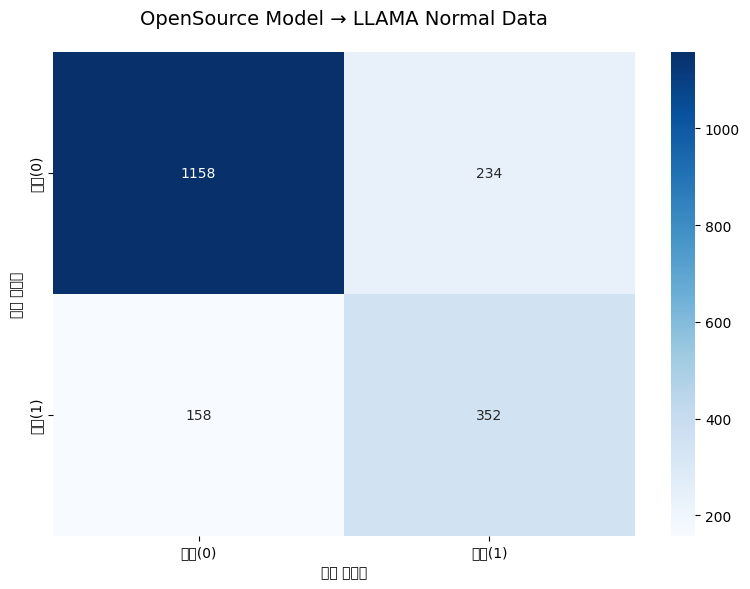


--- LLAMA Specific 데이터 ---



평가 데이터: LLAMA Specific
Accuracy: 0.8294
F1-Score: 0.7310

Confusion Matrix:
[[918  36]
 [226 356]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.80      0.96      0.88       954
       피싱(1)       0.91      0.61      0.73       582

    accuracy                           0.83      1536
   macro avg       0.86      0.79      0.80      1536
weighted avg       0.84      0.83      0.82      1536



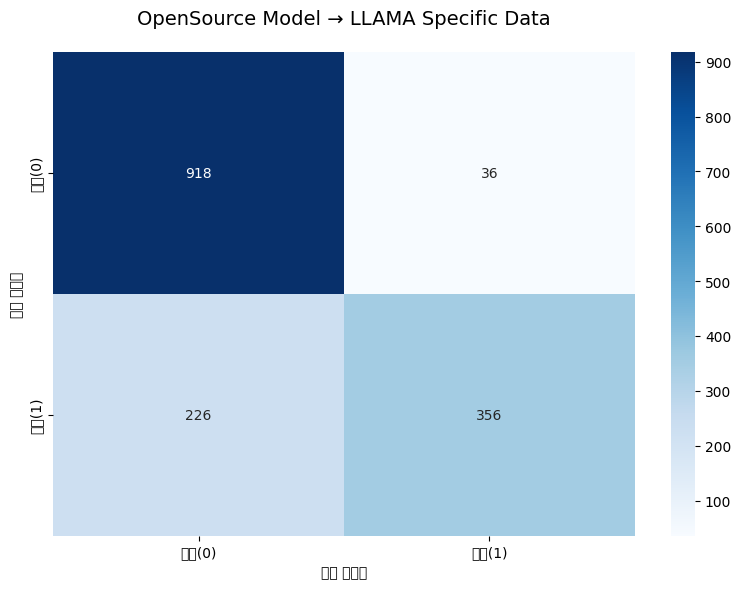


************************************************************
OpenSource 모델 → Gemini 데이터
************************************************************

--- Gemini Normal 데이터 ---



평가 데이터: Gemini Normal
Accuracy: 0.9344
F1-Score: 0.9099

Confusion Matrix:
[[974  84]
 [ 22 535]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.98      0.92      0.95      1058
       피싱(1)       0.86      0.96      0.91       557

    accuracy                           0.93      1615
   macro avg       0.92      0.94      0.93      1615
weighted avg       0.94      0.93      0.94      1615



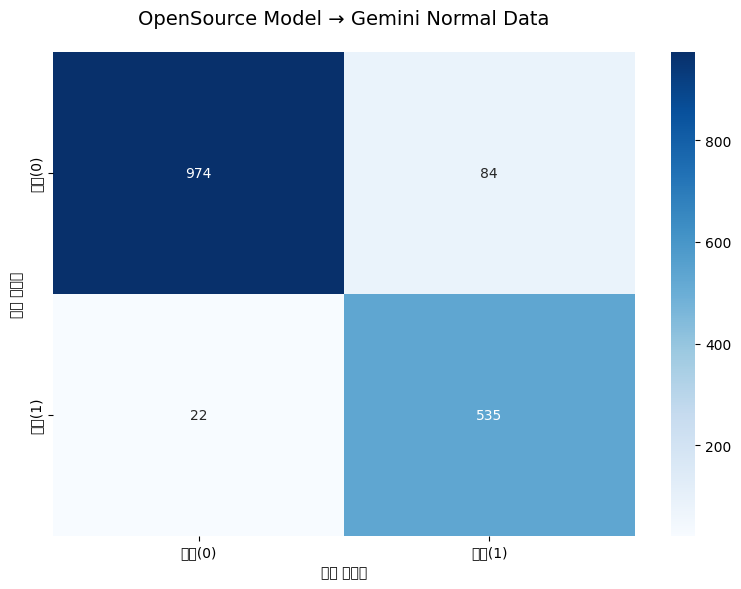


--- Gemini Specific 데이터 ---



평가 데이터: Gemini Specific
Accuracy: 0.3870
F1-Score: 0.4086

Confusion Matrix:
[[283 832]
 [158 342]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.64      0.25      0.36      1115
       피싱(1)       0.29      0.68      0.41       500

    accuracy                           0.39      1615
   macro avg       0.47      0.47      0.39      1615
weighted avg       0.53      0.39      0.38      1615



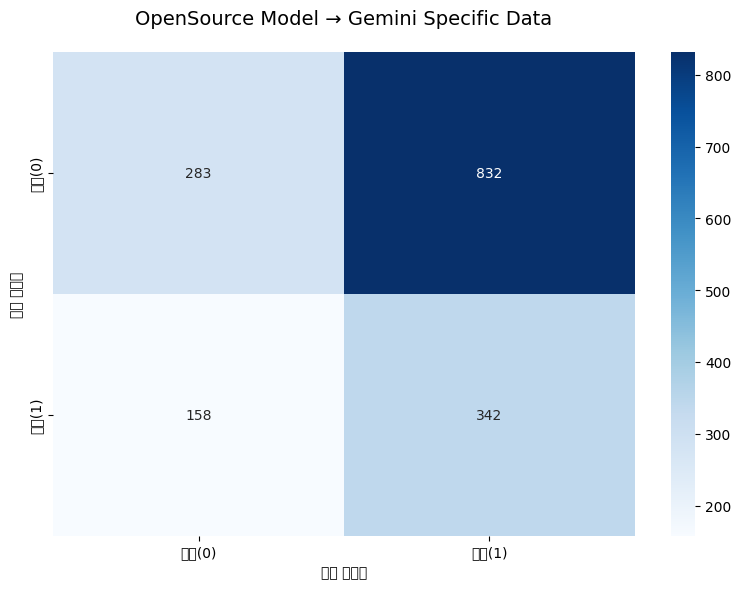


************************************************************
OpenSource 모델 → GPT 데이터
************************************************************

--- GPT Normal 데이터 ---



평가 데이터: GPT Normal
Accuracy: 0.7666
F1-Score: 0.5187

Confusion Matrix:
[[1024   33]
 [ 340  201]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.75      0.97      0.85      1057
       피싱(1)       0.86      0.37      0.52       541

    accuracy                           0.77      1598
   macro avg       0.80      0.67      0.68      1598
weighted avg       0.79      0.77      0.74      1598



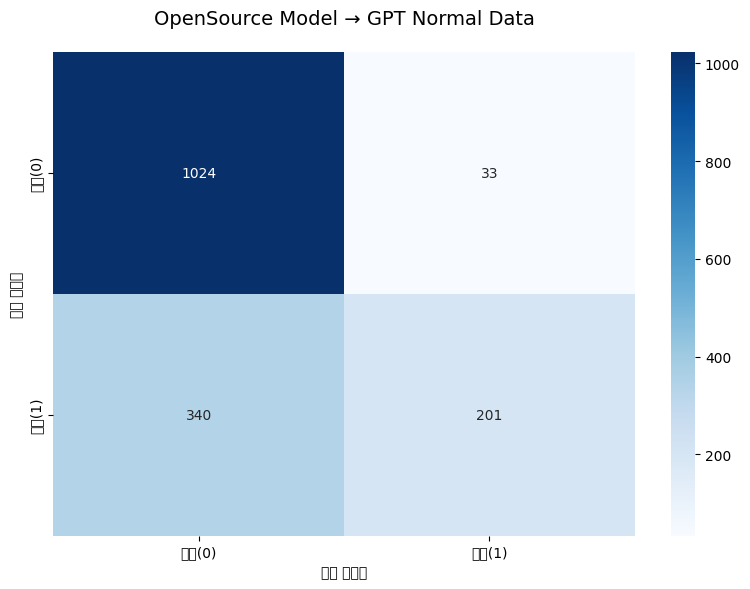


--- GPT Specific 데이터 ---



평가 데이터: GPT Specific
Accuracy: 0.5625
F1-Score: 0.2339

Confusion Matrix:
[[742 256]
 [399 100]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.65      0.74      0.69       998
       피싱(1)       0.28      0.20      0.23       499

    accuracy                           0.56      1497
   macro avg       0.47      0.47      0.46      1497
weighted avg       0.53      0.56      0.54      1497



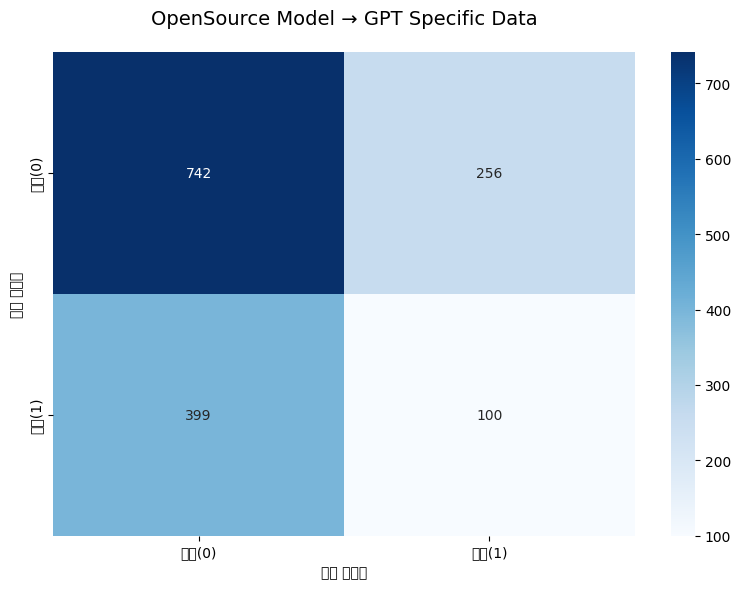


OpenSource 모델 평가 완료!


In [10]:
# ===== 셀 10: OpenSource 모델 → LLM 데이터 평가 =====

print("="*80)
print("교차 검증: OpenSource 모델 → LLM 생성 데이터")
print("="*80)

for llm_name in ['LLAMA', 'Gemini', 'GPT']:
    print(f"\n{'*'*60}")
    print(f"OpenSource 모델 → {llm_name} 데이터")
    print(f"{'*'*60}")

    # Normal 데이터 평가
    print(f"\n--- {llm_name} Normal 데이터 ---")
    normal_data = data_dict[f'{llm_name.lower()}_normal']
    results = evaluate_model(models['opensource'], tokenizers['opensource'],
                            normal_data, MAX_LEN)
    all_results[f'OS→{llm_name}_normal'] = results
    print_evaluation_results(results, f"{llm_name} Normal")
    plot_confusion_matrix(results['confusion_matrix'],
                         f"OpenSource Model → {llm_name} Normal Data")

    # Specific 데이터 평가
    print(f"\n--- {llm_name} Specific 데이터 ---")
    specific_data = data_dict[f'{llm_name.lower()}_specific']
    results = evaluate_model(models['opensource'], tokenizers['opensource'],
                            specific_data, MAX_LEN)
    all_results[f'OS→{llm_name}_specific'] = results
    print_evaluation_results(results, f"{llm_name} Specific")
    plot_confusion_matrix(results['confusion_matrix'],
                         f"OpenSource Model → {llm_name} Specific Data")

print("\nOpenSource 모델 평가 완료!")

교차 검증: LLM 모델 → OpenSource 데이터

************************************************************
LLAMA 모델 → OpenSource 데이터
************************************************************



평가 데이터: OpenSource
Accuracy: 0.6726
F1-Score: 0.4642

Confusion Matrix:
[[2642  186]
 [1444  706]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.65      0.93      0.76      2828
       피싱(1)       0.79      0.33      0.46      2150

    accuracy                           0.67      4978
   macro avg       0.72      0.63      0.61      4978
weighted avg       0.71      0.67      0.63      4978



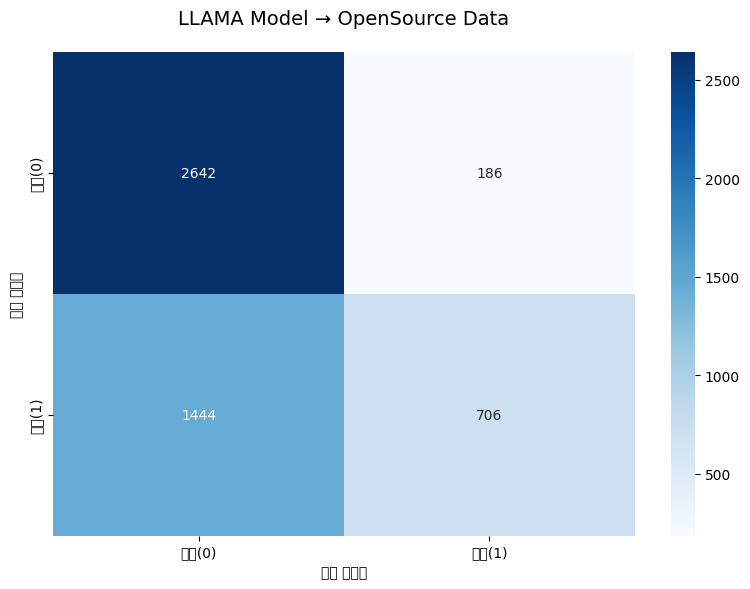


************************************************************
Gemini 모델 → OpenSource 데이터
************************************************************



평가 데이터: OpenSource
Accuracy: 0.9064
F1-Score: 0.8967

Confusion Matrix:
[[2490  338]
 [ 128 2022]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.95      0.88      0.91      2828
       피싱(1)       0.86      0.94      0.90      2150

    accuracy                           0.91      4978
   macro avg       0.90      0.91      0.91      4978
weighted avg       0.91      0.91      0.91      4978



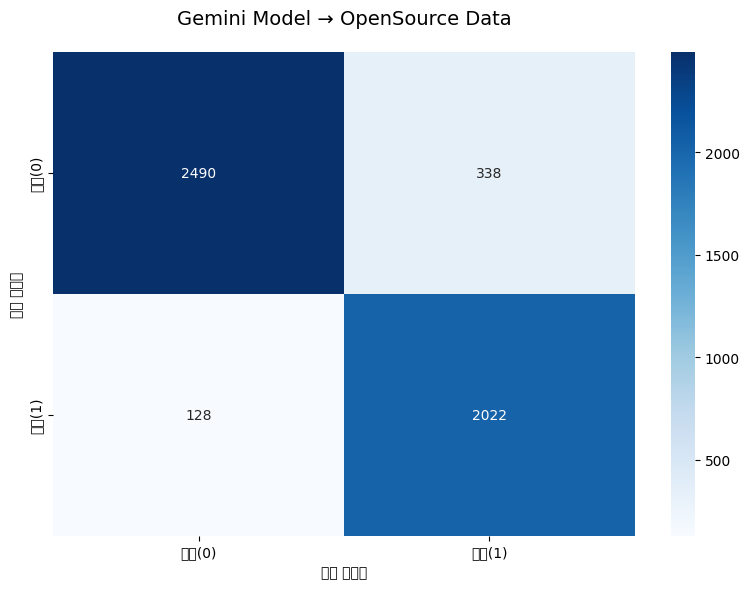


************************************************************
GPT 모델 → OpenSource 데이터
************************************************************



평가 데이터: OpenSource
Accuracy: 0.8515
F1-Score: 0.8351

Confusion Matrix:
[[2368  460]
 [ 279 1871]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.89      0.84      0.87      2828
       피싱(1)       0.80      0.87      0.84      2150

    accuracy                           0.85      4978
   macro avg       0.85      0.85      0.85      4978
weighted avg       0.85      0.85      0.85      4978



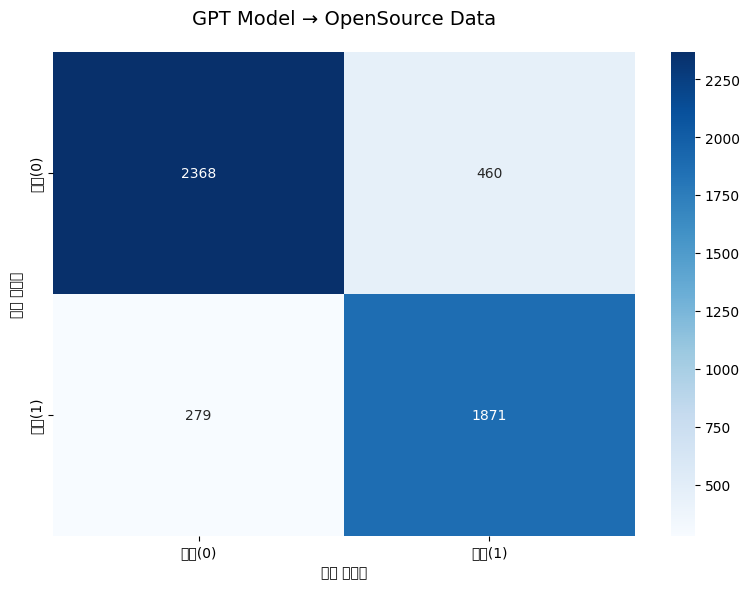


LLM 모델 평가 완료!


In [11]:
# ===== 셀 11: LLM 모델 → OpenSource 데이터 평가 =====

print("="*80)
print("교차 검증: LLM 모델 → OpenSource 데이터")
print("="*80)

for llm_name in ['LLAMA', 'Gemini', 'GPT']:
    print(f"\n{'*'*60}")
    print(f"{llm_name} 모델 → OpenSource 데이터")
    print(f"{'*'*60}")

    results = evaluate_model(models[llm_name], tokenizers[llm_name],
                            data_dict['opensource'], MAX_LEN)
    all_results[f'{llm_name}→OS'] = results
    print_evaluation_results(results, "OpenSource")
    plot_confusion_matrix(results['confusion_matrix'],
                         f"{llm_name} Model → OpenSource Data")

print("\nLLM 모델 평가 완료!")

In [12]:
# ===== 셀 12: 결과 종합 및 분석 =====

print("="*80)
print("결과 종합")
print("="*80)

# 결과 테이블 생성
results_summary = []

for key, result in all_results.items():
    results_summary.append({
        '평가': key,
        'Accuracy': f"{result['accuracy']:.4f}",
        'F1-Score': f"{result['f1_score']:.4f}",
        'TN': result['confusion_matrix'][0][0],
        'FP': result['confusion_matrix'][0][1],
        'FN': result['confusion_matrix'][1][0],
        'TP': result['confusion_matrix'][1][1]
    })

summary_df = pd.DataFrame(results_summary)
print("\n전체 결과 요약:")
print(summary_df.to_string(index=False))

# CSV로 저장
summary_df.to_csv('cross_validation_results.csv', index=False, encoding='utf-8-sig')
print("\n결과가 'cross_validation_results.csv'로 저장되었습니다.")

# 분석 인사이트
print("\n"+"="*80)
print("분석 인사이트")
print("="*80)

print("\n1. OpenSource 모델의 LLM 데이터 평가:")
for llm_name in ['LLAMA', 'Gemini', 'GPT']:
    normal_acc = all_results[f'OS→{llm_name}_normal']['accuracy']
    specific_acc = all_results[f'OS→{llm_name}_specific']['accuracy']
    normal_f1 = all_results[f'OS→{llm_name}_normal']['f1_score']
    specific_f1 = all_results[f'OS→{llm_name}_specific']['f1_score']

    print(f"\n  [{llm_name}]")
    print(f"    Normal  - Acc: {normal_acc:.4f}, F1: {normal_f1:.4f}")
    print(f"    Specific - Acc: {specific_acc:.4f}, F1: {specific_f1:.4f}")
    print(f"    Specific 성능 {'향상' if specific_acc > normal_acc else '저하'}: {abs(specific_acc - normal_acc):.4f}")

print("\n2. LLM 모델의 OpenSource 데이터 평가:")
for llm_name in ['LLAMA', 'Gemini', 'GPT']:
    acc = all_results[f'{llm_name}→OS']['accuracy']
    f1 = all_results[f'{llm_name}→OS']['f1_score']
    print(f"  {llm_name} → OpenSource: Acc={acc:.4f}, F1={f1:.4f}")

print("\n3. 데이터 품질 분석 (낮은 정확도 = 높은 다양성):")
llm_to_os_accs = {llm: all_results[f'{llm}→OS']['accuracy']
                  for llm in ['LLAMA', 'Gemini', 'GPT']}
best_diversity = min(llm_to_os_accs, key=llm_to_os_accs.get)
worst_diversity = max(llm_to_os_accs, key=llm_to_os_accs.get)
print(f"  가장 높은 언어/패턴 다양성: {best_diversity} (Acc: {llm_to_os_accs[best_diversity]:.4f})")
print(f"  가장 낮은 언어/패턴 다양성: {worst_diversity} (Acc: {llm_to_os_accs[worst_diversity]:.4f})")

print("\n"+"="*80)
print("실험 완료!")
print("="*80)

결과 종합

전체 결과 요약:
                평가 Accuracy F1-Score   TN  FP   FN   TP
   OS→LLAMA_normal   0.7939   0.6423 1158 234  158  352
 OS→LLAMA_specific   0.8294   0.7310  918  36  226  356
  OS→Gemini_normal   0.9344   0.9099  974  84   22  535
OS→Gemini_specific   0.3870   0.4086  283 832  158  342
     OS→GPT_normal   0.7666   0.5187 1024  33  340  201
   OS→GPT_specific   0.5625   0.2339  742 256  399  100
          LLAMA→OS   0.6726   0.4642 2642 186 1444  706
         Gemini→OS   0.9064   0.8967 2490 338  128 2022
            GPT→OS   0.8515   0.8351 2368 460  279 1871

결과가 'cross_validation_results.csv'로 저장되었습니다.

분석 인사이트

1. OpenSource 모델의 LLM 데이터 평가:

  [LLAMA]
    Normal  - Acc: 0.7939, F1: 0.6423
    Specific - Acc: 0.8294, F1: 0.7310
    Specific 성능 향상: 0.0355

  [Gemini]
    Normal  - Acc: 0.9344, F1: 0.9099
    Specific - Acc: 0.3870, F1: 0.4086
    Specific 성능 저하: 0.5474

  [GPT]
    Normal  - Acc: 0.7666, F1: 0.5187
    Specific - Acc: 0.5625, F1: 0.2339
    Specific 성능 저하: 

📊 OpenSource 모델 → LLM 전체 데이터 평가 (Normal + Specific 통합)

************************************************************
OpenSource 모델 → LLAMA 전체 데이터
************************************************************



평가 데이터: LLAMA 전체
Accuracy: 0.8098
F1-Score: 0.6841

Confusion Matrix:
[[2076  270]
 [ 384  708]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.84      0.88      0.86      2346
       피싱(1)       0.72      0.65      0.68      1092

    accuracy                           0.81      3438
   macro avg       0.78      0.77      0.77      3438
weighted avg       0.81      0.81      0.81      3438



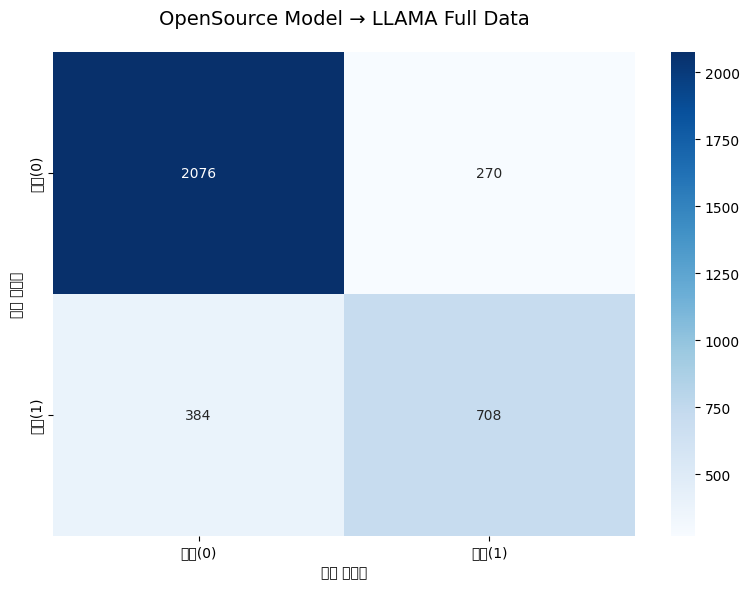


  📋 데이터 구성:
    Normal:   1,902개
    Specific: 1,536개
    전체:     3,438개

************************************************************
OpenSource 모델 → Gemini 전체 데이터
************************************************************



평가 데이터: Gemini 전체
Accuracy: 0.6607
F1-Score: 0.6154

Confusion Matrix:
[[1257  916]
 [ 180  877]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.87      0.58      0.70      2173
       피싱(1)       0.49      0.83      0.62      1057

    accuracy                           0.66      3230
   macro avg       0.68      0.70      0.66      3230
weighted avg       0.75      0.66      0.67      3230



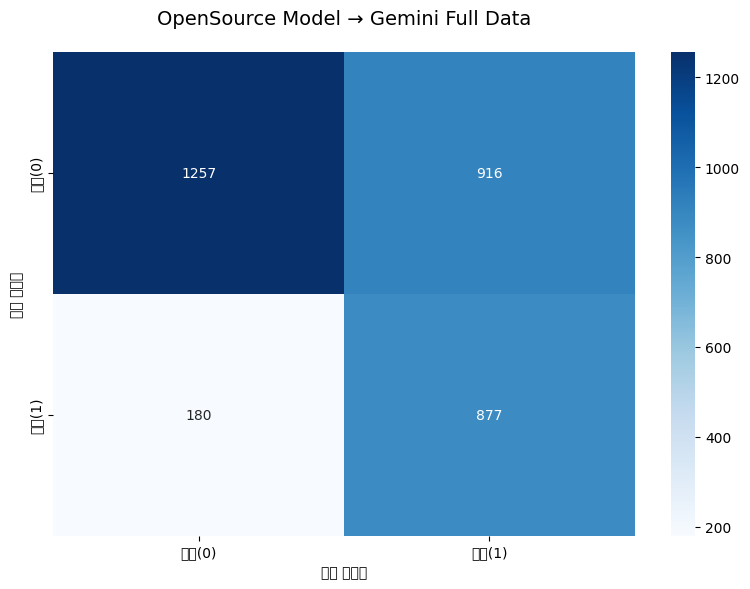


  📋 데이터 구성:
    Normal:   1,615개
    Specific: 1,615개
    전체:     3,230개

************************************************************
OpenSource 모델 → GPT 전체 데이터
************************************************************



평가 데이터: GPT 전체
Accuracy: 0.6679
F1-Score: 0.3693

Confusion Matrix:
[[1766  289]
 [ 739  301]]

Classification Report:
              precision    recall  f1-score   support

       정상(0)       0.70      0.86      0.77      2055
       피싱(1)       0.51      0.29      0.37      1040

    accuracy                           0.67      3095
   macro avg       0.61      0.57      0.57      3095
weighted avg       0.64      0.67      0.64      3095



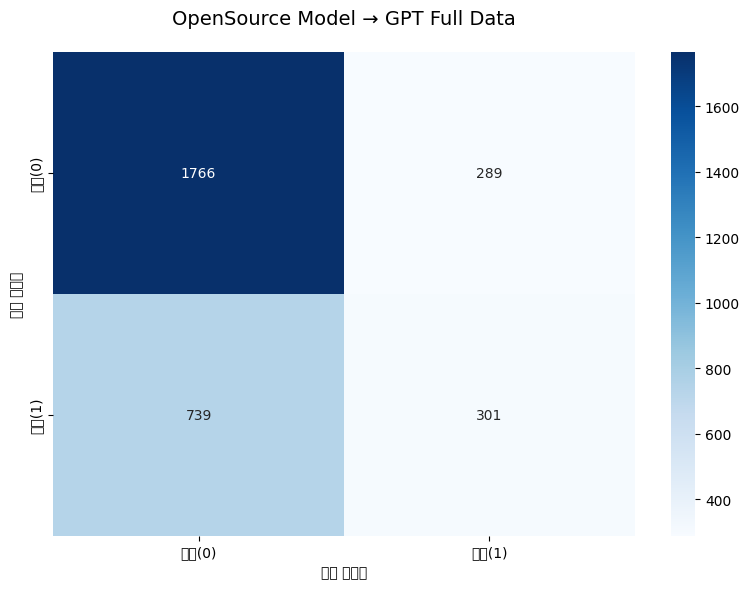


  📋 데이터 구성:
    Normal:   1,598개
    Specific: 1,497개
    전체:     3,095개


📊 OpenSource → LLM 전체 평가 결과 요약

전체 데이터 평가 결과:
       평가 Accuracy F1-Score   TN  FP  FN  TP
 OS→LLAMA   0.8098   0.6841 2076 270 384 708
OS→Gemini   0.6607   0.6154 1257 916 180 877
   OS→GPT   0.6679   0.3693 1766 289 739 301

결과가 'os_to_llm_full_results.csv'로 저장되었습니다.


📈 Normal/Specific 개별 vs 전체 비교

【LLAMA】
--------------------------------------------------------------------------------
구분           Accuracy     F1-Score    
--------------------------------------------------------------------------------
Normal       0.7939       0.6423      
Specific     0.8294       0.7310      
전체 통합        0.8098       0.6841      
가중 평균        0.8098       0.6820      

  💡 전체 통합 vs 가중 평균 차이:
     Accuracy: 0.0000
     F1-Score: 0.0021

【Gemini】
--------------------------------------------------------------------------------
구분           Accuracy     F1-Score    
----------------------------------------------------------

In [13]:
# ===== 추가 셀: OpenSource 모델 → LLM 전체 데이터 평가 =====

print("="*80)
print("📊 OpenSource 모델 → LLM 전체 데이터 평가 (Normal + Specific 통합)")
print("="*80)

# 전체 평가 결과 저장
all_results_full = {}

for llm_name in ['LLAMA', 'Gemini', 'GPT']:
    print(f"\n{'*'*60}")
    print(f"OpenSource 모델 → {llm_name} 전체 데이터")
    print(f"{'*'*60}")

    # Normal + Specific 통합 데이터
    llm_full_data = llm_datasets[llm_name]

    # 평가
    results = evaluate_model(models['opensource'], tokenizers['opensource'],
                            llm_full_data, MAX_LEN)
    all_results_full[f'OS→{llm_name}'] = results

    # 결과 출력
    print_evaluation_results(results, f"{llm_name} 전체")
    plot_confusion_matrix(results['confusion_matrix'],
                         f"OpenSource Model → {llm_name} Full Data")

    # 세부 통계
    normal_data = data_dict[f'{llm_name.lower()}_normal']
    specific_data = data_dict[f'{llm_name.lower()}_specific']

    print(f"\n  📋 데이터 구성:")
    print(f"    Normal:   {len(normal_data):,}개")
    print(f"    Specific: {len(specific_data):,}개")
    print(f"    전체:     {len(llm_full_data):,}개")

# ============================================================================
# 결과 요약 테이블
# ============================================================================

print("\n\n"+"="*80)
print("📊 OpenSource → LLM 전체 평가 결과 요약")
print("="*80)

full_summary = []

for key, result in all_results_full.items():
    full_summary.append({
        '평가': key,
        'Accuracy': f"{result['accuracy']:.4f}",
        'F1-Score': f"{result['f1_score']:.4f}",
        'TN': result['confusion_matrix'][0][0],
        'FP': result['confusion_matrix'][0][1],
        'FN': result['confusion_matrix'][1][0],
        'TP': result['confusion_matrix'][1][1]
    })

full_summary_df = pd.DataFrame(full_summary)
print("\n전체 데이터 평가 결과:")
print(full_summary_df.to_string(index=False))

# CSV 저장
full_summary_df.to_csv('os_to_llm_full_results.csv', index=False, encoding='utf-8-sig')
print("\n결과가 'os_to_llm_full_results.csv'로 저장되었습니다.")

# ============================================================================
# Normal/Specific 개별 vs 전체 비교
# ============================================================================

print("\n\n"+"="*80)
print("📈 Normal/Specific 개별 vs 전체 비교")
print("="*80)

for llm_name in ['LLAMA', 'Gemini', 'GPT']:
    print(f"\n【{llm_name}】")
    print("-"*80)

    # 개별 결과 (기존)
    normal_key = f'OS→{llm_name}_normal'
    specific_key = f'OS→{llm_name}_specific'
    full_key = f'OS→{llm_name}'

    if normal_key in all_results and specific_key in all_results:
        normal_acc = all_results[normal_key]['accuracy']
        normal_f1 = all_results[normal_key]['f1_score']

        specific_acc = all_results[specific_key]['accuracy']
        specific_f1 = all_results[specific_key]['f1_score']

        full_acc = all_results_full[full_key]['accuracy']
        full_f1 = all_results_full[full_key]['f1_score']

        print(f"{'구분':<12} {'Accuracy':<12} {'F1-Score':<12}")
        print("-"*80)
        print(f"{'Normal':<12} {normal_acc:<12.4f} {normal_f1:<12.4f}")
        print(f"{'Specific':<12} {specific_acc:<12.4f} {specific_f1:<12.4f}")
        print(f"{'전체 통합':<12} {full_acc:<12.4f} {full_f1:<12.4f}")

        # 가중 평균 계산 (참고)
        normal_count = len(data_dict[f'{llm_name.lower()}_normal'])
        specific_count = len(data_dict[f'{llm_name.lower()}_specific'])
        total_count = normal_count + specific_count

        weighted_acc = (normal_acc * normal_count + specific_acc * specific_count) / total_count
        weighted_f1 = (normal_f1 * normal_count + specific_f1 * specific_count) / total_count

        print(f"{'가중 평균':<12} {weighted_acc:<12.4f} {weighted_f1:<12.4f}")
        print(f"\n  💡 전체 통합 vs 가중 평균 차이:")
        print(f"     Accuracy: {abs(full_acc - weighted_acc):.4f}")
        print(f"     F1-Score: {abs(full_f1 - weighted_f1):.4f}")

print("\n✅ OpenSource → LLM 전체 평가 완료!")

#언어다양성 체크

In [14]:
# ===== 언어적 다양성 정량화 분석 =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("📊 언어적 다양성 정량화 분석")
print("="*80)
print("\n목적: OS 데이터 vs Gemini 생성 vs GPT 생성의 언어적 다양성 비교")
print("측정 지표: TTR, 문장 길이, n-gram 분포, 희귀 어휘 비율\n")

# ============================================================================
# 1. 데이터 준비 (이미 로드된 데이터 사용)
# ============================================================================

print("="*80)
print("1단계: 데이터 준비")
print("="*80)

# 분석 대상 데이터셋
datasets = {
    'OpenSource': data_dict['opensource'],
    'Gemini': llm_datasets['Gemini'],
    'GPT': llm_datasets['GPT']
}

# 데이터 통계
for name, df in datasets.items():
    print(f"\n[{name}]")
    print(f"  총 샘플: {len(df):,}개")
    print(f"  정상(0): {(df['label']==0).sum():,}개")
    print(f"  피싱(1): {(df['label']==1).sum():,}개")

# ============================================================================
# 2. 전처리 함수
# ============================================================================

def preprocess_text(text):
    """기본 전처리: 소문자 변환, 특수문자 유지"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    return text

def tokenize_simple(text):
    """단순 토큰화: 공백 기준 분리"""
    return text.split()

def get_tokens(texts):
    """텍스트 리스트를 토큰 리스트로 변환"""
    all_tokens = []
    for text in texts:
        processed = preprocess_text(text)
        tokens = tokenize_simple(processed)
        all_tokens.extend(tokens)
    return all_tokens

# ============================================================================
# 3. 다양성 지표 계산 함수
# ============================================================================

def calculate_ttr(texts):
    """
    Type-Token Ratio (TTR) 계산
    TTR = 고유 단어 수 / 전체 단어 수
    높을수록 어휘가 다양함
    """
    tokens = get_tokens(texts)
    if len(tokens) == 0:
        return 0

    types = len(set(tokens))  # 고유 단어 수
    tokens_count = len(tokens)  # 전체 단어 수

    ttr = types / tokens_count
    return ttr, types, tokens_count

def calculate_msttr(texts, window_size=100):
    """
    Moving-average Type-Token Ratio (MSTTR)
    긴 텍스트에서 TTR이 낮아지는 문제 해결
    """
    all_tokens = get_tokens(texts)

    if len(all_tokens) < window_size:
        return calculate_ttr(texts)[0]

    ttrs = []
    for i in range(0, len(all_tokens) - window_size + 1, window_size):
        window_tokens = all_tokens[i:i + window_size]
        window_types = len(set(window_tokens))
        ttrs.append(window_types / window_size)

    return np.mean(ttrs) if ttrs else 0

def calculate_sentence_stats(texts):
    """
    문장 길이 통계 계산
    - 평균, 표준편차, 중앙값
    """
    lengths = []
    for text in texts:
        processed = preprocess_text(text)
        tokens = tokenize_simple(processed)
        lengths.append(len(tokens))

    return {
        'mean': np.mean(lengths),
        'std': np.std(lengths),
        'median': np.median(lengths),
        'min': np.min(lengths),
        'max': np.max(lengths)
    }

def get_ngram_distribution(texts, n=2, top_k=20):
    """
    상위 n-gram 분포
    n: n-gram 크기 (1=unigram, 2=bigram, 3=trigram)
    """
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        max_features=10000,
        lowercase=True,
        token_pattern=r'\b\w+\b'
    )

    try:
        X = vectorizer.fit_transform(texts)
        vocab = vectorizer.get_feature_names_out()
        counts = X.sum(axis=0).A1

        # 상위 k개
        top_indices = counts.argsort()[-top_k:][::-1]
        top_ngrams = [(vocab[i], counts[i]) for i in top_indices]

        # 전체 n-gram 수
        total_ngrams = counts.sum()

        # 상위 k개가 차지하는 비율
        top_k_ratio = sum([count for _, count in top_ngrams]) / total_ngrams

        return top_ngrams, top_k_ratio, len(vocab)
    except:
        return [], 0, 0

def calculate_rare_word_ratio(texts, threshold=2):
    """
    희귀 어휘 비율 계산
    threshold: 이 횟수 이하로 등장하는 단어를 '희귀'로 간주
    """
    tokens = get_tokens(texts)
    token_counts = Counter(tokens)

    rare_tokens = [token for token, count in token_counts.items() if count <= threshold]
    rare_ratio = len(rare_tokens) / len(token_counts) if len(token_counts) > 0 else 0

    return rare_ratio, len(rare_tokens), len(token_counts)

def calculate_vocabulary_richness(texts):
    """
    어휘 풍부도 지표들
    """
    tokens = get_tokens(texts)
    token_counts = Counter(tokens)

    # 단 한 번만 등장하는 단어 (hapax legomena)
    hapax = sum(1 for count in token_counts.values() if count == 1)

    # 두 번만 등장하는 단어 (dis legomena)
    dis = sum(1 for count in token_counts.values() if count == 2)

    # Yule's K (어휘 다양성 지표, 낮을수록 다양함)
    N = len(tokens)
    if N == 0:
        yules_k = 0
    else:
        freq_spectrum = Counter(token_counts.values())
        M1 = len(token_counts)
        M2 = sum(freq * (count ** 2) for count, freq in freq_spectrum.items())
        yules_k = 10000 * (M2 - M1) / (N ** 2) if N > 0 else 0

    return {
        'hapax_count': hapax,
        'dis_count': dis,
        'hapax_ratio': hapax / len(token_counts) if len(token_counts) > 0 else 0,
        'yules_k': yules_k
    }

print("\n✅ 전처리 및 분석 함수 정의 완료!")

📊 언어적 다양성 정량화 분석

목적: OS 데이터 vs Gemini 생성 vs GPT 생성의 언어적 다양성 비교
측정 지표: TTR, 문장 길이, n-gram 분포, 희귀 어휘 비율

1단계: 데이터 준비

[OpenSource]
  총 샘플: 4,978개
  정상(0): 2,828개
  피싱(1): 2,150개

[Gemini]
  총 샘플: 3,230개
  정상(0): 2,173개
  피싱(1): 1,057개

[GPT]
  총 샘플: 3,095개
  정상(0): 2,055개
  피싱(1): 1,040개

✅ 전처리 및 분석 함수 정의 완료!


In [15]:
# ===== 언어적 다양성 분석 실행 =====

print("="*80)
print("2단계: 언어적 다양성 지표 계산")
print("="*80)

# 결과 저장용 딕셔너리
diversity_results = {}

for dataset_name, df in datasets.items():
    print(f"\n{'='*80}")
    print(f"[{dataset_name}] 분석 중...")
    print(f"{'='*80}")

    texts = df['dialogue'].tolist()

    results = {}

    # 1. Type-Token Ratio (TTR)
    print("\n1️⃣  Type-Token Ratio (TTR)")
    ttr, types, tokens = calculate_ttr(texts)
    msttr = calculate_msttr(texts, window_size=100)

    results['ttr'] = ttr
    results['msttr'] = msttr
    results['types'] = types
    results['tokens'] = tokens

    print(f"  TTR:           {ttr:.4f}")
    print(f"  MSTTR (w=100): {msttr:.4f}")
    print(f"  고유 단어 수:   {types:,}개")
    print(f"  전체 단어 수:   {tokens:,}개")

    # 2. 문장 길이 통계
    print("\n2️⃣  문장 길이 통계")
    sent_stats = calculate_sentence_stats(texts)
    results['sent_stats'] = sent_stats

    print(f"  평균 길이:     {sent_stats['mean']:.2f} 단어")
    print(f"  표준편차:      {sent_stats['std']:.2f}")
    print(f"  중앙값:        {sent_stats['median']:.0f} 단어")
    print(f"  최소/최대:     {sent_stats['min']:.0f} / {sent_stats['max']:.0f} 단어")

    # 3. Unigram (1-gram) 분포
    print("\n3️⃣  Unigram (단어) 분포")
    top_unigrams, uni_ratio, uni_vocab_size = get_ngram_distribution(texts, n=1, top_k=20)
    results['top_unigrams'] = top_unigrams
    results['unigram_top20_ratio'] = uni_ratio
    results['unigram_vocab_size'] = uni_vocab_size

    print(f"  전체 어휘 크기:        {uni_vocab_size:,}개")
    print(f"  상위 20개 비중:        {uni_ratio*100:.2f}%")
    print(f"  상위 5개 단어:")
    for i, (word, count) in enumerate(top_unigrams[:5], 1):
        print(f"    {i}. '{word}': {int(count):,}회")

    # 4. Bigram (2-gram) 분포
    print("\n4️⃣  Bigram (2-단어 조합) 분포")
    top_bigrams, bi_ratio, bi_vocab_size = get_ngram_distribution(texts, n=2, top_k=20)
    results['top_bigrams'] = top_bigrams
    results['bigram_top20_ratio'] = bi_ratio
    results['bigram_vocab_size'] = bi_vocab_size

    print(f"  전체 bigram 수:        {bi_vocab_size:,}개")
    print(f"  상위 20개 비중:        {bi_ratio*100:.2f}%")
    print(f"  상위 5개 bigram:")
    for i, (bigram, count) in enumerate(top_bigrams[:5], 1):
        print(f"    {i}. '{bigram}': {int(count):,}회")

    # 5. 희귀 어휘 비율
    print("\n5️⃣  희귀 어휘 비율 (등장 횟수 ≤ 2)")
    rare_ratio, rare_count, total_vocab = calculate_rare_word_ratio(texts, threshold=2)
    results['rare_ratio'] = rare_ratio
    results['rare_count'] = rare_count
    results['total_vocab'] = total_vocab

    print(f"  희귀 단어 수:          {rare_count:,}개")
    print(f"  전체 어휘 수:          {total_vocab:,}개")
    print(f"  희귀 어휘 비율:        {rare_ratio*100:.2f}%")

    # 6. 어휘 풍부도
    print("\n6️⃣  어휘 풍부도 지표")
    richness = calculate_vocabulary_richness(texts)
    results['richness'] = richness

    print(f"  Hapax (1회 단어):      {richness['hapax_count']:,}개 ({richness['hapax_ratio']*100:.2f}%)")
    print(f"  Dis (2회 단어):        {richness['dis_count']:,}개")
    print(f"  Yule's K:              {richness['yules_k']:.2f} (낮을수록 다양)")

    diversity_results[dataset_name] = results

print("\n\n✅ 모든 데이터셋 분석 완료!")

2단계: 언어적 다양성 지표 계산

[OpenSource] 분석 중...

1️⃣  Type-Token Ratio (TTR)
  TTR:           0.0815
  MSTTR (w=100): 0.8219
  고유 단어 수:   295,446개
  전체 단어 수:   3,625,924개

2️⃣  문장 길이 통계
  평균 길이:     728.39 단어
  표준편차:      670.45
  중앙값:        514 단어
  최소/최대:     3 / 7179 단어

3️⃣  Unigram (단어) 분포
  전체 어휘 크기:        10,000개
  상위 20개 비중:        18.10%
  상위 5개 단어:
    1. '그': 59,948회
    2. '뭐': 40,417회
    3. '거': 40,217회
    4. '어': 37,976회
    5. '그런': 32,495회

4️⃣  Bigram (2-단어 조합) 분포
  전체 bigram 수:        10,000개
  상위 20개 비중:        6.61%
  상위 5개 bigram:
    1. '거 같아요': 8,174회
    2. '거 같아': 6,336회
    3. '수 있는': 5,166회
    4. '할 수': 2,951회
    5. '네 네': 2,570회

5️⃣  희귀 어휘 비율 (등장 횟수 ≤ 2)
  희귀 단어 수:          218,950개
  전체 어휘 수:          295,446개
  희귀 어휘 비율:        74.11%

6️⃣  어휘 풍부도 지표
  Hapax (1회 단어):      178,499개 (60.42%)
  Dis (2회 단어):        40,451개
  Yule's K:              16.07 (낮을수록 다양)

[Gemini] 분석 중...

1️⃣  Type-Token Ratio (TTR)
  TTR:           0.1024
  MSTTR (w=100): 0.8222
  고

3단계: 데이터셋 간 비교 분석

📊 언어적 다양성 종합 비교표

      데이터셋      TTR    MSTTR   고유단어    전체단어       평균길이     길이표준편차  Unigram수  Bigram수  희귀어비율(%)  Hapax비율(%)  Yule's K
OpenSource 0.081482 0.821851 295446 3625924 728.389715 670.452440     10000    10000 74.108297   60.416794 16.070601
    Gemini 0.102387 0.822180  52339  511186 158.261920 158.758754     10000    10000 71.776304   56.625079 30.620838
       GPT 0.112369 0.822144  40210  357838 115.618094 163.367145     10000    10000 74.260134   60.300920 26.663258



결과가 'linguistic_diversity_comparison.csv'로 저장되었습니다.


📈 핵심 다양성 지표 비교

지표                   OpenSource      Gemini          GPT            
--------------------------------------------------------------------------------
TTR                  0.0815          0.1024          0.1124         
MSTTR                0.8219          0.8222          0.8221         
평균 문장 길이             728.39          158.26          115.62         
희귀어 비율(%)            74.11           71.78           74.26          
Yule's K             16.07           30.62           26.66          


🏆 언어적 다양성 순위

【TTR (높을수록 다양)】
  🥇 1위: GPT          0.1124
  🥈 2위: Gemini       0.1024
  🥉 3위: OpenSource   0.0815

【MSTTR (높을수록 다양)】
  🥇 1위: Gemini       0.8222
  🥈 2위: GPT          0.8221
  🥉 3위: OpenSource   0.8219

【희귀어 비율 (높을수록 다양)】
  🥇 1위: GPT          74.26%
  🥈 2위: OpenSource   74.11%
  🥉 3위: Gemini       71.78%

【Hapax 비율 (높을수록 다양)】
  🥇 1위: OpenSource   60.42%
  🥈 2위: GPT          60.30%
  🥉 3위: Gemini       56.63%

【Yul

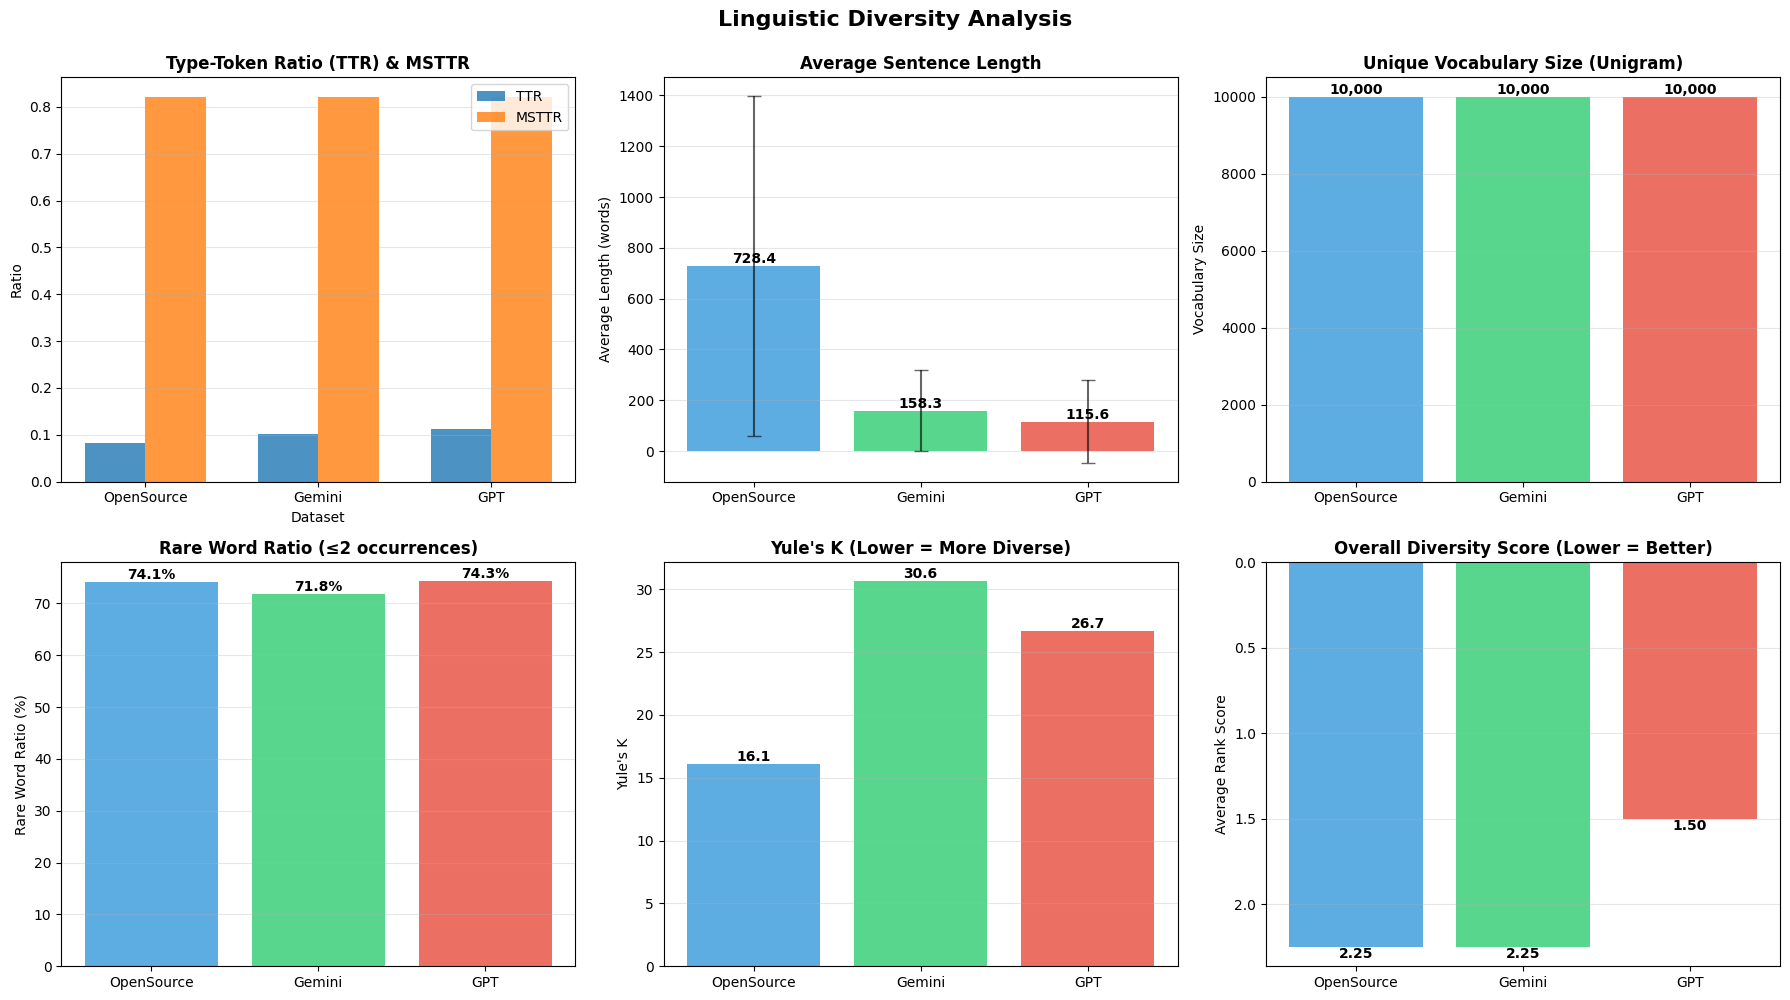


✅ 시각화 완료!


In [16]:
# ===== 언어적 다양성 비교 및 시각화 =====

print("="*80)
print("3단계: 데이터셋 간 비교 분석")
print("="*80)

# ============================================================================
# 1. 비교 테이블 생성
# ============================================================================

print("\n📊 언어적 다양성 종합 비교표")
print("="*80)

comparison_data = []

for dataset_name in ['OpenSource', 'Gemini', 'GPT']:
    results = diversity_results[dataset_name]

    comparison_data.append({
        '데이터셋': dataset_name,
        'TTR': results['ttr'],
        'MSTTR': results['msttr'],
        '고유단어': results['types'],
        '전체단어': results['tokens'],
        '평균길이': results['sent_stats']['mean'],
        '길이표준편차': results['sent_stats']['std'],
        'Unigram수': results['unigram_vocab_size'],
        'Bigram수': results['bigram_vocab_size'],
        '희귀어비율(%)': results['rare_ratio'] * 100,
        'Hapax비율(%)': results['richness']['hapax_ratio'] * 100,
        "Yule's K": results['richness']['yules_k']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + comparison_df.to_string(index=False))

# CSV 저장
comparison_df.to_csv('linguistic_diversity_comparison.csv', index=False, encoding='utf-8-sig')
print("\n결과가 'linguistic_diversity_comparison.csv'로 저장되었습니다.")

# ============================================================================
# 2. 핵심 지표 비교
# ============================================================================

print("\n\n" + "="*80)
print("📈 핵심 다양성 지표 비교")
print("="*80)

# OpenSource를 기준으로 비교
baseline = diversity_results['OpenSource']

print(f"\n{'지표':<20} {'OpenSource':<15} {'Gemini':<15} {'GPT':<15}")
print("-"*80)

# TTR 비교
print(f"{'TTR':<20} {baseline['ttr']:<15.4f} "
      f"{diversity_results['Gemini']['ttr']:<15.4f} "
      f"{diversity_results['GPT']['ttr']:<15.4f}")

# MSTTR 비교
print(f"{'MSTTR':<20} {baseline['msttr']:<15.4f} "
      f"{diversity_results['Gemini']['msttr']:<15.4f} "
      f"{diversity_results['GPT']['msttr']:<15.4f}")

# 평균 문장 길이
print(f"{'평균 문장 길이':<20} {baseline['sent_stats']['mean']:<15.2f} "
      f"{diversity_results['Gemini']['sent_stats']['mean']:<15.2f} "
      f"{diversity_results['GPT']['sent_stats']['mean']:<15.2f}")

# 희귀어 비율
print(f"{'희귀어 비율(%)':<20} {baseline['rare_ratio']*100:<15.2f} "
      f"{diversity_results['Gemini']['rare_ratio']*100:<15.2f} "
      f"{diversity_results['GPT']['rare_ratio']*100:<15.2f}")

# Yule's K
print(f"{"Yule's K":<20} {baseline['richness']['yules_k']:<15.2f} "
      f"{diversity_results['Gemini']['richness']['yules_k']:<15.2f} "
      f"{diversity_results['GPT']['richness']['yules_k']:<15.2f}")

# ============================================================================
# 3. 다양성 순위
# ============================================================================

print("\n\n" + "="*80)
print("🏆 언어적 다양성 순위")
print("="*80)

# 각 지표별 순위 (높을수록 다양함)
metrics = {
    'TTR (높을수록 다양)': 'ttr',
    'MSTTR (높을수록 다양)': 'msttr',
    '희귀어 비율 (높을수록 다양)': 'rare_ratio',
    'Hapax 비율 (높을수록 다양)': ('richness', 'hapax_ratio'),
}

for metric_name, metric_key in metrics.items():
    print(f"\n【{metric_name}】")

    values = {}
    for dataset_name in ['OpenSource', 'Gemini', 'GPT']:
        if isinstance(metric_key, tuple):
            value = diversity_results[dataset_name][metric_key[0]][metric_key[1]]
        else:
            value = diversity_results[dataset_name][metric_key]
        values[dataset_name] = value

    sorted_datasets = sorted(values.items(), key=lambda x: x[1], reverse=True)

    for rank, (dataset, value) in enumerate(sorted_datasets, 1):
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
        if metric_name.startswith('TTR') or metric_name.startswith('MSTTR'):
            print(f"  {medal} {rank}위: {dataset:<12} {value:.4f}")
        else:
            print(f"  {medal} {rank}위: {dataset:<12} {value*100:.2f}%")

# Yule's K (낮을수록 다양함)
print(f"\n【Yule's K (낮을수록 다양)】")
yules_values = {name: diversity_results[name]['richness']['yules_k']
                for name in ['OpenSource', 'Gemini', 'GPT']}
sorted_yules = sorted(yules_values.items(), key=lambda x: x[1])

for rank, (dataset, value) in enumerate(sorted_yules, 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"  {medal} {rank}위: {dataset:<12} {value:.2f}")

# ============================================================================
# 4. 종합 점수
# ============================================================================

print("\n\n" + "="*80)
print("📊 종합 다양성 점수")
print("="*80)
print("\n점수 계산 방식: 각 지표별 순위의 평균 (1위=1점, 2위=2점, 3위=3점)")
print("낮을수록 다양성이 높음\n")

scores = {name: [] for name in ['OpenSource', 'Gemini', 'GPT']}

# TTR
ttr_values = {name: diversity_results[name]['ttr'] for name in ['OpenSource', 'Gemini', 'GPT']}
ttr_ranks = {name: rank for rank, (name, _) in enumerate(sorted(ttr_values.items(), key=lambda x: x[1], reverse=True), 1)}
for name, rank in ttr_ranks.items():
    scores[name].append(rank)

# MSTTR
msttr_values = {name: diversity_results[name]['msttr'] for name in ['OpenSource', 'Gemini', 'GPT']}
msttr_ranks = {name: rank for rank, (name, _) in enumerate(sorted(msttr_values.items(), key=lambda x: x[1], reverse=True), 1)}
for name, rank in msttr_ranks.items():
    scores[name].append(rank)

# 희귀어 비율
rare_values = {name: diversity_results[name]['rare_ratio'] for name in ['OpenSource', 'Gemini', 'GPT']}
rare_ranks = {name: rank for rank, (name, _) in enumerate(sorted(rare_values.items(), key=lambda x: x[1], reverse=True), 1)}
for name, rank in rare_ranks.items():
    scores[name].append(rank)

# Yule's K (낮을수록 좋음)
yules_ranks = {name: rank for rank, (name, _) in enumerate(sorted(yules_values.items(), key=lambda x: x[1]), 1)}
for name, rank in yules_ranks.items():
    scores[name].append(rank)

# 평균 점수 계산
avg_scores = {name: np.mean(score_list) for name, score_list in scores.items()}
sorted_scores = sorted(avg_scores.items(), key=lambda x: x[1])

for rank, (dataset, score) in enumerate(sorted_scores, 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"{medal} {rank}위: {dataset:<12} 평균 {score:.2f}점")

# ============================================================================
# 5. 시각화
# ============================================================================

print("\n\n" + "="*80)
print("📊 시각화")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

datasets_list = ['OpenSource', 'Gemini', 'GPT']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# 1. TTR & MSTTR 비교
ax1 = axes[0, 0]
x = np.arange(len(datasets_list))
width = 0.35
ttr_vals = [diversity_results[d]['ttr'] for d in datasets_list]
msttr_vals = [diversity_results[d]['msttr'] for d in datasets_list]

ax1.bar(x - width/2, ttr_vals, width, label='TTR', alpha=0.8)
ax1.bar(x + width/2, msttr_vals, width, label='MSTTR', alpha=0.8)
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Ratio')
ax1.set_title('Type-Token Ratio (TTR) & MSTTR', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets_list)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. 평균 문장 길이
ax2 = axes[0, 1]
mean_lens = [diversity_results[d]['sent_stats']['mean'] for d in datasets_list]
std_lens = [diversity_results[d]['sent_stats']['std'] for d in datasets_list]

bars = ax2.bar(datasets_list, mean_lens, color=colors, alpha=0.8)
ax2.errorbar(datasets_list, mean_lens, yerr=std_lens, fmt='none',
             ecolor='black', capsize=5, alpha=0.6)
ax2.set_ylabel('Average Length (words)')
ax2.set_title('Average Sentence Length', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, mean_lens):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# 3. 어휘 크기 (Unigram)
ax3 = axes[0, 2]
vocab_sizes = [diversity_results[d]['unigram_vocab_size'] for d in datasets_list]
bars = ax3.bar(datasets_list, vocab_sizes, color=colors, alpha=0.8)
ax3.set_ylabel('Vocabulary Size')
ax3.set_title('Unique Vocabulary Size (Unigram)', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, vocab_sizes):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:,}', ha='center', va='bottom', fontweight='bold')

# 4. 희귀어 비율
ax4 = axes[1, 0]
rare_ratios = [diversity_results[d]['rare_ratio']*100 for d in datasets_list]
bars = ax4.bar(datasets_list, rare_ratios, color=colors, alpha=0.8)
ax4.set_ylabel('Rare Word Ratio (%)')
ax4.set_title('Rare Word Ratio (≤2 occurrences)', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, rare_ratios):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# 5. Yule's K
ax5 = axes[1, 1]
yules_vals = [diversity_results[d]['richness']['yules_k'] for d in datasets_list]
bars = ax5.bar(datasets_list, yules_vals, color=colors, alpha=0.8)
ax5.set_ylabel("Yule's K")
ax5.set_title("Yule's K (Lower = More Diverse)", fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, yules_vals):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# 6. 종합 점수
ax6 = axes[1, 2]
score_vals = [avg_scores[d] for d in datasets_list]
bars = ax6.bar(datasets_list, score_vals, color=colors, alpha=0.8)
ax6.set_ylabel('Average Rank Score')
ax6.set_title('Overall Diversity Score (Lower = Better)', fontweight='bold')
ax6.grid(axis='y', alpha=0.3)
ax6.invert_yaxis()  # 낮을수록 좋으므로 반전

for bar, val in zip(bars, score_vals):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.2f}', ha='center', va='top', fontweight='bold')

plt.suptitle('Linguistic Diversity Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ 시각화 완료!")